Modeling salmon spawning.

Aim to model the relationship between the number of spawning salmon within a stream, and the number of fry entering the population later that spring.

1. Specify and construct model
2. Evaluate postierior distribution
3. Check the model

In [39]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

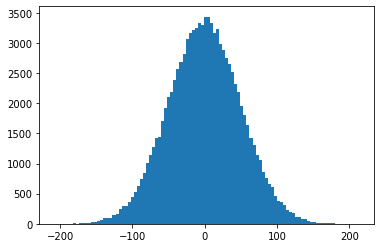

In [40]:
a_normal_distribution = pm.Normal.dist(mu=0, sigma=50)
plt.hist(a_normal_distribution.random(size=100000), bins=100);

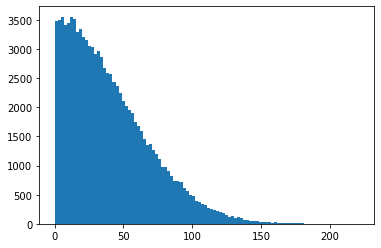

In [41]:
a_half_normal_distribution = pm.HalfNormal.dist(sigma=50)
plt.hist(a_half_normal_distribution.random(size=100000), bins=100);

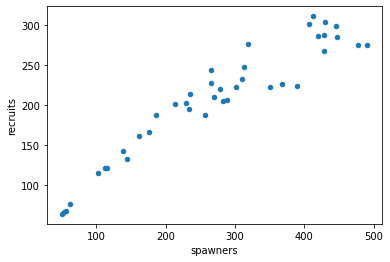

In [42]:
data = pd.read_table('../data/salmon.txt', sep='\s+')
data.plot.scatter(x='spawners', y='recruits');

Simple linear regression:

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

$$ \epsilon_i \sim N(0, \sigma) $$

There are three unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

In [43]:
x, y = data[['spawners', 'recruits']].values.T

In [44]:
with pm.Model() as lin_salmon_model:
    # Components treated as random
    beta = pm.Normal('β', mu=0, sigma=50, shape=2)
    sigma = pm.HalfNormal('σ', sigma=50)

    # Proposed formula.
    mu = beta[0] + (beta[1] * x)

    # Data is fixed.
    recruits = pm.Normal('recruits', mu=mu, sigma=sigma, observed=y)

In [45]:
with lin_salmon_model:
    lin_trace = pm.sample(1000, tune=2000, cores=4, chains=10)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [σ, β]


Sampling 10 chains for 2_000 tune and 1_000 draw iterations (20_000 + 10_000 draws total) took 42 seconds.


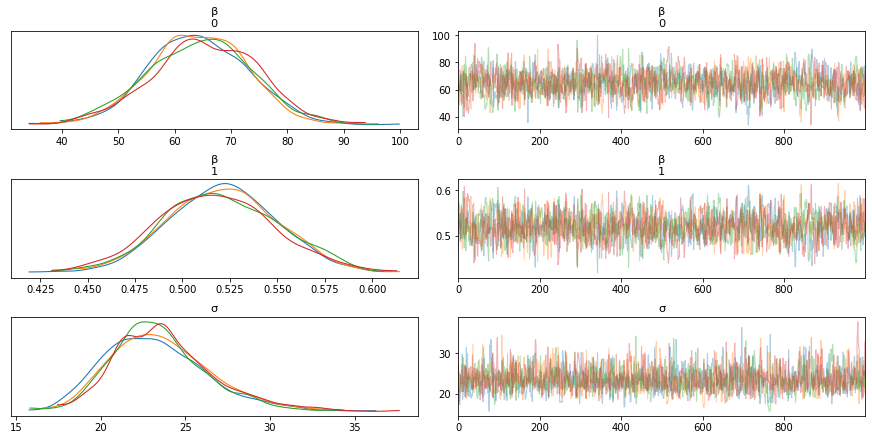

In [46]:
az.plot_trace(lin_trace);

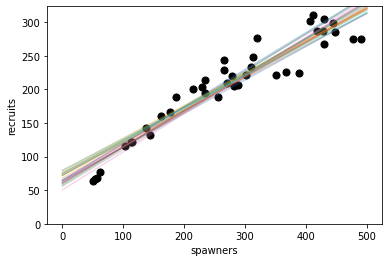

In [47]:
X_pred = np.linspace(0, 500, 100)

ax = data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for b0,b1 in lin_trace['β'][:20]:
    ax.plot(X_pred, b0 + b1*X_pred, alpha=0.3);